In [1]:
import numpy as np
import numpy.polynomial.polynomial as poly
import scipy as sp
import scipy.interpolate 
import math
from matplotlib import pyplot as plt
%matplotlib inline

import pickle

In [2]:
speakerN = 9
trainSamplesNs = [30] * speakerN
testSamplesNs = [31, 35, 88, 44, 29, 24, 40, 50, 29]
channelsN = 12

smoothLength = 4

In [23]:
# load raw data from file into a data structure
# data[speakernumber][samplenumber] = nparray[time, channel]
def loadData(name, sampleNs):
    speakers = []
    samples = []
    collector = []
    speakerNum = 0
    with open(name) as f:
        for line in f:
            line = line.replace('\r\n', '')
            if line.strip() == '':
                continue
            numbers = [float(x) for x in line.split()]
            if all([x == 1.0 for x in numbers]):
                samples.append(np.array(collector))
                collector = []
                if len(samples) == sampleNs[speakerNum]:
                    speakers.append(samples)
                    samples = []
                    speakerNum += 1
            else:
                collector.append(numbers)
    return speakers

trainDataRaw = loadData('ae.train', trainSamplesNs)
testDataRaw = loadData('ae.test', testSamplesNs)

In [24]:
# shift and scale both datasets according to properties of training data
def getShiftsAndScales(data):
    allData = np.zeros((0,channelsN))
    for speaker in data:
        for sample in speaker:
            allData = np.append(allData, sample, axis = 0)

    maxVals = allData.max(axis = 0)
    minVals = allData.min(axis = 0)
    shifts = -minVals
    scales = 1.0/(maxVals - minVals)
    return shifts, scales

def normalizeData(data, shifts, scales):
    newData = []
    for speaker_i, speaker in enumerate(data):
        newData.append([])
        for sample_i, sample in enumerate(speaker):
            sample += np.tile(shifts, (sample.shape[0], 1))
            sample = np.dot(sample, np.diag(scales))
            newData[speaker_i].append(sample)
    return newData
    
shifts, scales = getShiftsAndScales(trainDataRaw)
trainDataNormalized = normalizeData(trainDataRaw, shifts, scales)
testDataNormalized = normalizeData(testDataRaw, shifts, scales)

In [27]:
#Interpolate datapoints so that each sample has only four timesteps
def smoothenData(data, smoothLength):
    newData = []
    polyOrder = 3
    for speaker in data:
        newSpeaker = []
        for sample in speaker:
            newSample = np.zeros((smoothLength, channelsN))
            size = sample.shape[0]
            xVals = np.arange(1, size + 1)
            interpolCoords = np.linspace(1, size, smoothLength) 
            polycoeff = poly.polyfit(list(range(size)), sample, polyOrder)
            sampleSmooth = poly.polyval(list(range(size)), polycoeff)
            for channel_i in range(channelsN):
                f = sp.interpolate.interp1d(xVals, sampleSmooth[channel_i])
                newSample[:, channel_i] = f(interpolCoords)
            newSpeaker.append(newSample) 
        newData.append(newSpeaker)
    return newData

trainDataSmoothend = smoothenData(trainDataNormalized, smoothLength)
testDataSmoothend = smoothenData(testDataNormalized, smoothLength)

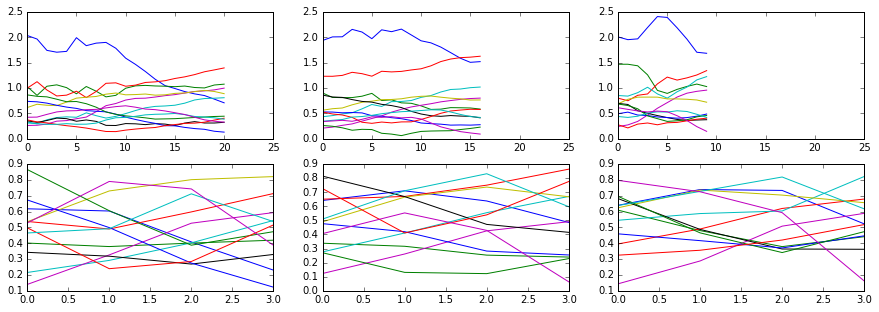

In [29]:
plt.figure(figsize=(15,5))
speakers = [4, 6, 8]
for speaker_i, speaker in enumerate(speakers):
    plt.subplot(2, len(speakers), speaker_i + 1)
    plt.xlim([0, 25])
    utteranceDataRaw = trainDataRaw[speaker - 1][0]
    for channel in range(channelsN):
        plt.plot(utteranceDataRaw[:, channel])
    
    plt.subplot(2, len(speakers), speaker_i + 1 + len(speakers))
    utteranceData = trainDataSmoothend[speaker - 1][0]
    for channel in range(channelsN):
        plt.plot(utteranceData[:, channel])
    

In [30]:
# save data
data = {
    'train': trainDataSmoothend,
    'test': testDataSmoothend
}
with open('prepdata.pickle', 'wb') as f:
    pickle.dump(data, f)